#   [Py4Hw User Guide](../UserGuide.ipynb)> 1.1 Design Style
###  [Next: 1.2 Object Oriented Approach](OO.ipynb)

Hardware design tools typically combine different design styles. 

1. Graphical
    1. Structural
2. Textual (HDL)
    1. Structural
    2. Register Transfer Level
    3. Behavioural

Textual description of Hardware is done by Hardware description languages (HDL). Most popular ones are Verilog, SystemVerilog, VHDL, and MyHDL (also based on Python). 

In **py4hw** we promote the use of structural design style, by reusing as much as possible already designed and proven modules.

In structural design styles a hardware module is build by instantiating other hardware modules and connecting them with wires.

Thus, to create a circuit, the hardware designer has to reuse existing available blocks and create new ones when needed.

By doing that, the design ends up being a set of blocks with a hierarchycal dependence. For instance, let A,B,C,D,E,F be preexisting logic blocks, and A being composed by B and C, and E being composed by A and F. If a hardware designer builds a circuit g reusing A and using a newly created block h using D and E. The hierarchical description of the circuit g would be the following. 

<pre>
g 
+- A
|  +- B
|  +- C
+--h
   +- D
   +- E
      +- A
      |  +- B
      |  +- C
      +- F
</pre>
  
In this case we would say that g is the **top level entity** of the hierarchy

In [1]:
import sys
import platform
if (platform.uname().node == 'TPY14'):
    print('Dev machine')
    sys.path.append('..\\..\\..\\py4hw')

Dev machine


In [2]:
import py4hw

In [3]:
# Imagine the following example
sys = py4hw.HWSystem()

inc = py4hw.Wire(sys, 'inc', 1)
count = py4hw.Wire(sys, 'count', 8)
q = py4hw.Wire(sys, 'q', 8)

py4hw.Constant(sys, 'inc', 1, inc)
py4hw.Add(sys, 'counter', q, inc, count)
py4hw.Reg(sys, 'reg', d=count, enable=inc, q=q)

print('circuit created')

circuit created


The following code shows prints the hierarchy of the system 

In [4]:
py4hw.debug.printHierarchy(sys)

HWSystem
 Constant
 Add
 Reg


You can add the current state of the inputs and outputs of each circuit of the hierarchy by using printHierarchyWithValues as shown in the following example 

In [5]:
for i in range(3):
    sys.getSimulator().clk(1)
    py4hw.debug.printHierarchyWithValues(sys)

HWSystem HWSystem () -> () 
 Constant inc () -> (r=1) 
 Add counter (a=1,b=1) -> (r=2) 
 Reg reg (d=2,e=1) -> (q=1) 
HWSystem HWSystem () -> () 
 Constant inc () -> (r=1) 
 Add counter (a=2,b=1) -> (r=3) 
 Reg reg (d=3,e=1) -> (q=2) 
HWSystem HWSystem () -> () 
 Constant inc () -> (r=1) 
 Add counter (a=3,b=1) -> (r=4) 
 Reg reg (d=4,e=1) -> (q=3) 


## Structural Design
Structural design consist on creating instances of other elements.
In **py4hw** this is done in the constructor of the class that implements the circuit.

In [7]:
sys = py4hw.HWSystem()

inc = py4hw.Wire(sys, 'inc', 1)
q = py4hw.Wire(sys, 'q', 8)

py4hw.Constant(sys, 'inc', 1, inc)

class Counter(py4hw.Logic):
    def __init__(self, parent, name, inc, q):
        super().__init__(parent, name)
    
        self.addIn('inc', inc)
        self.addOut('q', q)
        
        count = py4hw.Wire(sys, 'count', 8)

        py4hw.Add(self, 'counter', q, inc, count)
        py4hw.Reg(self, 'reg', d=count, enable=inc, q=q)

Counter(sys, 'counter', inc, q)

print('circuit created')

circuit created


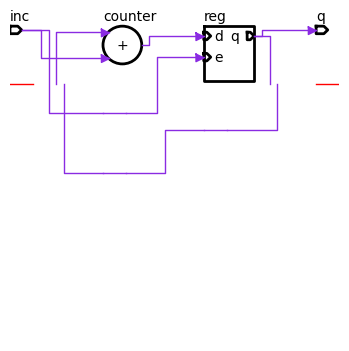

In [10]:
sch = py4hw.Schematic(sys.children['counter'])
sch.draw()

## Behavioural Modeling
Not all the circuits can be described structurally.

Some circuit primitives (like and, and or gates and registers) are already described behaviourally in the py4hw library.

There are two types of behavioural descriptions: combinational and sequential.

Combinational circuits are modelled by implementing the **propagate** method.

Sequential circuits are modelled by implementing the **clock** method.

